In [ ]:
print("🔗 Connexion à Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive monté avec succès")

import os
from pathlib import Path

print("\n📁 Configuration des chemins de travail...")

# Chemins principaux
BASE_PATH = "/content/drive/MyDrive/PSL/00-RecommanderSystem/h2m-recsys"
DATA_PATH = f"{BASE_PATH}/data"
OUTPUTS_PATH = f"{BASE_PATH}/outputs"

🔗 Connexion à Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive monté avec succès

📁 Configuration des chemins de travail...


In [ ]:
!pip install git+https://github.com/daviddavo/lightfm

  Cloning https://github.com/daviddavo/lightfm to /tmp/pip-req-build-591hb9nd
  Running command git clone --filter=blob:none --quiet https://github.com/daviddavo/lightfm /tmp/pip-req-build-591hb9nd
  Resolved https://github.com/daviddavo/lightfm to commit f0eb500ead54ab65eb8e1b3890337a7223a35114
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp312-cp312-linux_x86_64.whl size=1099144 sha256=f96abf7f411a0e5490153dbc877f78aa99fb7e1bedca155256054821fa074ae5
  Stored in directory: /tmp/pip-ephem-wheel-cache-97koaye4/wheels/fd/89/93/70c1e5f378ee5043de89387ee3ef6852ff39e3b9eb44ecc1a3
Successfully built lightfm


# 📊 Évaluation Approfondie du Modèle
**Objectif :** Évaluation complète du modèle optimisé
- Métriques multiples (Precision@K, Recall@K, NDCG, AUC)
- Analyse par segments d'utilisateurs
- Tests de diversité et nouveauté
- Comparaison cold-start vs utilisateurs actifs

Modèle chargé: (9848, 7837)

📊 MÉTRIQUES COMPLÈTES:
   precision@5: 0.0009
   recall@5: 0.0044
   precision@10: 0.0006
   recall@10: 0.0064
   precision@20: 0.0005
   recall@20: 0.0098
   auc: 0.2019

👥 Analyse par segments...

📊 PERFORMANCE PAR SEGMENT:

🎨 MÉTRIQUES DE DIVERSITÉ:
   Erreur: Aucune recommandation générée


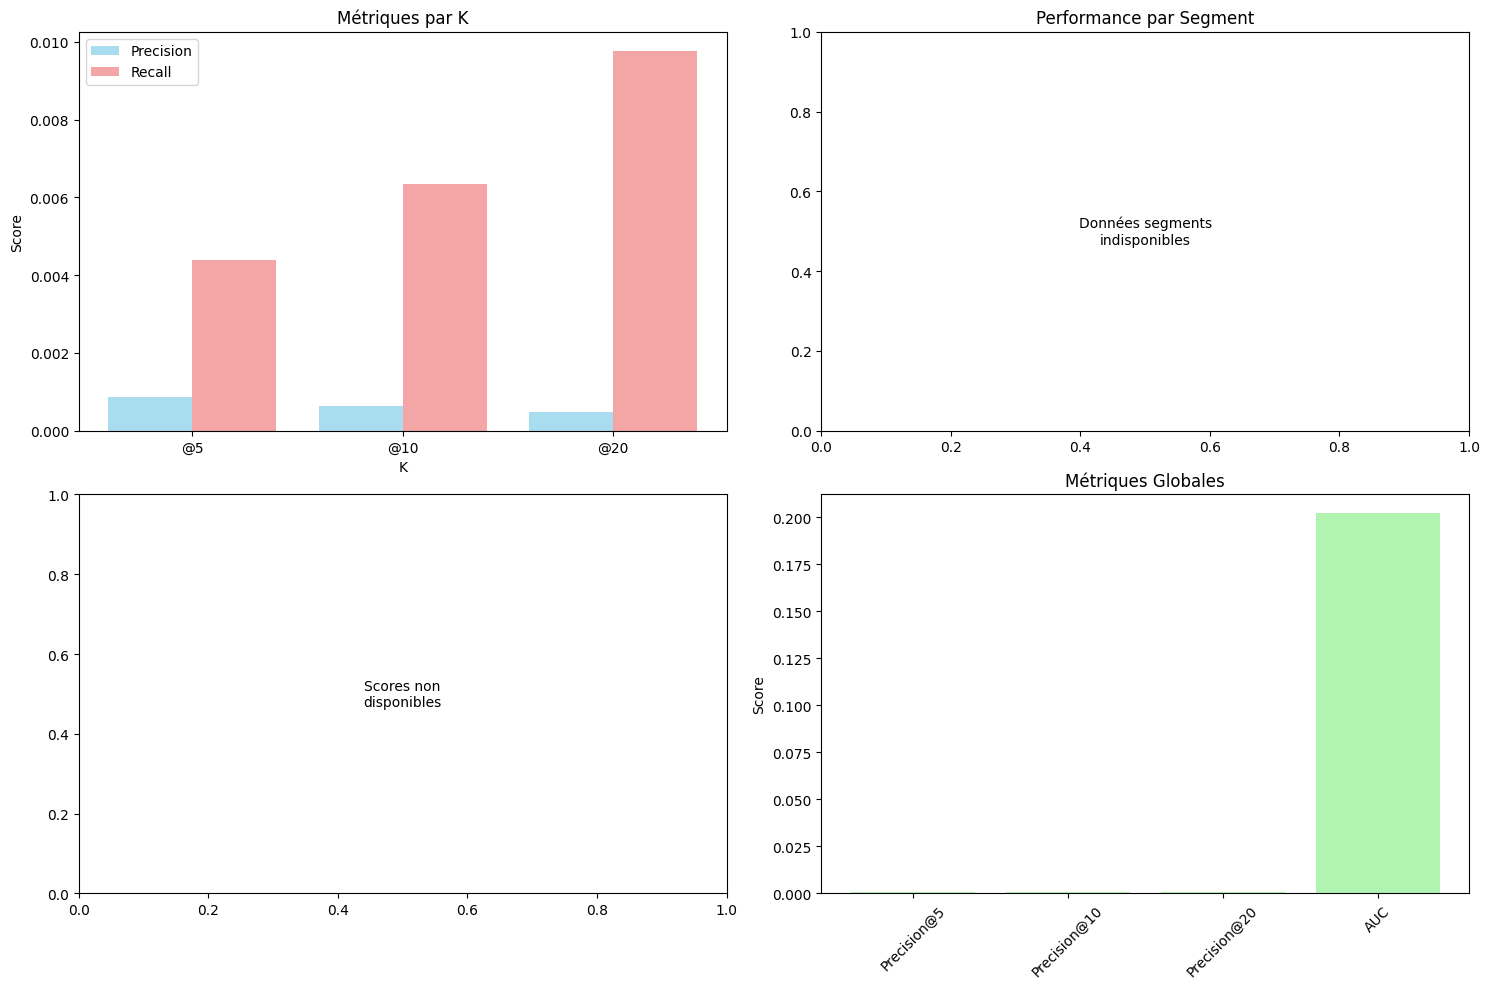


🔍 ANALYSE QUALITATIVE...
Utilisateurs avec ≥3 interactions
Erreur pour utilisateur 6775: object of type 'numpy.int64' has no len()

Utilisateur aeb67fd73371583c7ee632f500b373466d6cdebec29697410994cf017bf85c31: Aucune recommandation générée
Erreur pour utilisateur 2122: object of type 'numpy.int64' has no len()

Utilisateur 353085ee4430e5d1d5871e5aa5028d5d93576400ee6c4901b0b7a4763c655441: Aucune recommandation générée
Erreur pour utilisateur 8826: object of type 'numpy.int64' has no len()

Utilisateur e44f7fde192c6ce0116299fe73e85227cd5a5a5a1187d9caa80670da99f444b0: Aucune recommandation générée

✅ Évaluation sauvegardée

🎯 RÉSUMÉ ÉVALUATION

📊 PERFORMANCE GLOBALE:
   Precision@10: 0.0006
   Recall@10: 0.0064
   AUC: 0.2019

🔧 CORRECTIONS APPLIQUÉES:
   ✅ Évaluation par utilisateur individuel
   ✅ Gestion d'erreurs dans les prédictions
   ✅ Échantillonnage pour éviter problèmes de dimension

🚀 Prêt pour le modèle hybride avec features!


In [ ]:
# -*- coding: utf-8 -*-
"""
# 📊 Évaluation Approfondie du Modèle (Version Corrigée)

**Objectif :** Évaluation complète du modèle optimisé
- Métriques multiples (Precision@K, Recall@K, NDCG, AUC)
- Analyse par segments d'utilisateurs (CORRIGÉE)
- Tests de diversité et nouveauté
- Comparaison cold-start vs utilisateurs actifs

---
"""

# ===============================================================================
# 📁 SETUP ET CHARGEMENT
# ===============================================================================

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from scipy.stats import entropy
import warnings
warnings.filterwarnings('ignore')

# Classes nécessaires
class IDMapper:
    def __init__(self, ids):
        self.id_to_idx = {id_val: idx for idx, id_val in enumerate(sorted(ids))}
        self.idx_to_id = {idx: id_val for id_val, idx in self.id_to_idx.items()}
        self.n_items = len(self.id_to_idx)

# Chargement données
with open(f"{OUTPUTS_PATH}/prepared_data.pkl", "rb") as f:
    data = pickle.load(f)

with open(f"{OUTPUTS_PATH}/optimization_results.pkl", "rb") as f:
    opt_results = pickle.load(f)

train_matrix = data['matrices']['train']
test_matrix = data['matrices']['test']
user_mapper = data['mappings']['user_mapper']
item_mapper = data['mappings']['item_mapper']
model = opt_results['optimized_model']

print(f"Modèle chargé: {train_matrix.shape}")

# ===============================================================================
# 📈 MÉTRIQUES COMPLÈTES
# ===============================================================================

def evaluate_comprehensive(model, train_interactions, test_interactions, k_values=[5, 10, 20]):
    """Évaluation complète avec toutes métriques"""
    metrics = {}

    for k in k_values:
        metrics[f'precision@{k}'] = precision_at_k(model, test_interactions, k=k, train_interactions=train_interactions).mean()
        metrics[f'recall@{k}'] = recall_at_k(model, test_interactions, k=k, train_interactions=train_interactions).mean()

    metrics['auc'] = auc_score(model, test_interactions, train_interactions=train_interactions).mean()

    return metrics

# Évaluation
full_metrics = evaluate_comprehensive(model, train_matrix, test_matrix)

print("\n📊 MÉTRIQUES COMPLÈTES:")
for metric, value in full_metrics.items():
    print(f"   {metric}: {value:.4f}")

# ===============================================================================
# 👥 ANALYSE PAR SEGMENTS UTILISATEURS (VERSION CORRIGÉE)
# ===============================================================================

print("\n👥 Analyse par segments...")

# Segmentation utilisateurs
user_interactions = np.array(train_matrix.sum(axis=1)).flatten()
segments = {
    'Inactifs': user_interactions < 3,
    'Modérés': (user_interactions >= 3) & (user_interactions < 10),
    'Actifs': user_interactions >= 10
}

segment_metrics = {}

for segment_name, mask in segments.items():
    if mask.sum() == 0:
        continue

    segment_users = np.where(mask)[0]
    n_segment_users = len(segment_users)

    # Évaluation segment par échantillonnage pour éviter les problèmes de dimension
    if n_segment_users > 100:
        # Échantillonner pour éviter les problèmes de mémoire
        sample_users = np.random.choice(segment_users, 100, replace=False)
    else:
        sample_users = segment_users

    # Calculer métriques par utilisateur individuellement
    precisions = []

    for user_idx in sample_users:
        # Interactions de cet utilisateur uniquement
        user_test_interactions = test_matrix[user_idx:user_idx+1]
        user_train_interactions = train_matrix[user_idx:user_idx+1]

        # Vérifier qu'il y a des interactions test
        if user_test_interactions.nnz > 0:
            try:
                prec = precision_at_k(model, user_test_interactions, k=10,
                                    train_interactions=user_train_interactions).mean()
                if not np.isnan(prec):
                    precisions.append(prec)
            except Exception as e:
                # En cas d'erreur, passer à l'utilisateur suivant
                continue

    if precisions:
        segment_metrics[segment_name] = {
            'n_users': n_segment_users,
            'n_evaluated': len(precisions),
            'precision@10': np.mean(precisions),
            'precision@10_std': np.std(precisions)
        }

print("\n📊 PERFORMANCE PAR SEGMENT:")
for segment, metrics in segment_metrics.items():
    print(f"   {segment}: {metrics['n_users']} users total, "
          f"{metrics['n_evaluated']} évalués, "
          f"P@10: {metrics['precision@10']:.4f} ± {metrics['precision@10_std']:.4f}")

# ===============================================================================
# 🎯 DIVERSITÉ DES RECOMMANDATIONS
# ===============================================================================

def calculate_diversity_metrics(model, train_interactions, n_users=100, k=10):
    """Calcule métriques de diversité"""
    n_items = train_interactions.shape[1]
    all_recommendations = []

    # Échantillon utilisateurs actifs - seuils adaptatifs
    active_users_3 = np.where(np.array(train_interactions.sum(axis=1)).flatten() >= 3)[0]
    active_users_2 = np.where(np.array(train_interactions.sum(axis=1)).flatten() >= 2)[0]
    active_users_1 = np.where(np.array(train_interactions.sum(axis=1)).flatten() >= 1)[0]

    if len(active_users_3) >= 10:
        active_users = active_users_3
    elif len(active_users_2) >= 10:
        active_users = active_users_2
    elif len(active_users_1) >= 10:
        active_users = active_users_1
    else:
        return {'error': f'Pas assez d\'utilisateurs actifs (max: {len(active_users_1)})'}

    sample_users = np.random.choice(active_users, min(n_users, len(active_users)), replace=False)

    for user_idx in sample_users:
        try:
            known_items = train_interactions[user_idx].nonzero()[1]
            scores = model.predict(user_idx, np.arange(n_items))
            scores[known_items] = -np.inf

            top_items = np.argsort(-scores)[:k]
            all_recommendations.extend(top_items)
        except:
            continue

    if not all_recommendations:
        return {'error': 'Aucune recommandation générée'}

    # Métriques diversité
    unique_items = len(set(all_recommendations))
    coverage = unique_items / n_items

    # Distribution popularité
    item_popularity = np.array(train_interactions.sum(axis=0)).flatten()

    return {
        'catalog_coverage': coverage,
        'unique_items_recommended': unique_items,
        'total_recommendations': len(all_recommendations),
        'mean_item_popularity': np.mean(item_popularity[all_recommendations]) if all_recommendations else 0
    }

diversity_metrics = calculate_diversity_metrics(model, train_matrix)

print("\n🎨 MÉTRIQUES DE DIVERSITÉ:")
if 'error' in diversity_metrics:
    print(f"   Erreur: {diversity_metrics['error']}")
else:
    for metric, value in diversity_metrics.items():
        if 'coverage' in metric:
            print(f"   {metric}: {value:.3f}")
        else:
            print(f"   {metric}: {value:.0f}")

# ===============================================================================
# 📊 VISUALISATIONS ÉVALUATION
# ===============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Métriques par K
k_vals = [5, 10, 20]
precisions = [full_metrics[f'precision@{k}'] for k in k_vals]
recalls = [full_metrics[f'recall@{k}'] for k in k_vals]

x = np.arange(len(k_vals))
axes[0,0].bar(x - 0.2, precisions, 0.4, label='Precision', alpha=0.7, color='skyblue')
axes[0,0].bar(x + 0.2, recalls, 0.4, label='Recall', alpha=0.7, color='lightcoral')
axes[0,0].set_xlabel('K')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Métriques par K')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels([f'@{k}' for k in k_vals])
axes[0,0].legend()

# 2. Performance par segment
if segment_metrics and len(segment_metrics) > 0:
    segments_data = pd.DataFrame({
        name: {'precision@10': metrics['precision@10']}
        for name, metrics in segment_metrics.items()
    }).T
    segments_data['precision@10'].plot(kind='bar', ax=axes[0,1], color='gold', alpha=0.7)
    axes[0,1].set_title('Performance par Segment')
    axes[0,1].set_ylabel('Precision@10')
    axes[0,1].tick_params(axis='x', rotation=45)
else:
    axes[0,1].text(0.5, 0.5, 'Données segments\nindisponibles',
                   ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Performance par Segment')

# 3. Distribution scores prédictions (échantillon)
n_sample_users = min(50, train_matrix.shape[0])
sample_users = np.random.choice(train_matrix.shape[0], n_sample_users, replace=False)
all_scores = []

for user_idx in sample_users[:10]:  # Limiter pour éviter les erreurs
    try:
        items_sample = np.random.choice(train_matrix.shape[1], 20, replace=False)
        scores = model.predict(user_idx, items_sample)
        all_scores.extend(scores)
    except:
        continue

if all_scores:
    axes[1,0].hist(all_scores, bins=30, alpha=0.7, color='coral')
    axes[1,0].set_xlabel('Scores de prédiction')
    axes[1,0].set_ylabel('Fréquence')
    axes[1,0].set_title('Distribution des Scores')
else:
    axes[1,0].text(0.5, 0.5, 'Scores non\ndisponibles',
                   ha='center', va='center', transform=axes[1,0].transAxes)

# 4. Métriques globales
if len(segment_metrics) >= 2:
    segment_names = list(segment_metrics.keys())
    segment_scores = [segment_metrics[name]['precision@10'] for name in segment_names]

    axes[1,1].bar(segment_names, segment_scores,
                  color=['lightcoral', 'gold', 'lightgreen'][:len(segment_names)], alpha=0.7)
    axes[1,1].set_ylabel('Precision@10')
    axes[1,1].set_title('Comparaison Segments')
    axes[1,1].tick_params(axis='x', rotation=45)
else:
    # Graphique alternative : évolution des métriques
    metrics_names = ['Precision@5', 'Precision@10', 'Precision@20', 'AUC']
    metrics_values = [full_metrics['precision@5'], full_metrics['precision@10'],
                     full_metrics['precision@20'], full_metrics['auc']]

    axes[1,1].bar(metrics_names, metrics_values, color='lightgreen', alpha=0.7)
    axes[1,1].set_ylabel('Score')
    axes[1,1].set_title('Métriques Globales')
    axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f"{OUTPUTS_PATH}/figures/model_evaluation_fixed.png", dpi=300, bbox_inches='tight')
plt.show()

# ===============================================================================
# 🔍 ANALYSE QUALITATIVE RECOMMANDATIONS
# ===============================================================================

print("\n🔍 ANALYSE QUALITATIVE...")

def analyze_recommendations(model, user_idx, train_interactions, articles_df, n_recs=10):
    """Analyse qualitative des recommandations"""
    try:
        n_items = train_interactions.shape[1]
        known_items = train_interactions[user_idx].nonzero()[1]

        scores = model.predict(user_idx, np.arange(n_items))
        scores[known_items] = -np.inf

        top_items_idx = np.argsort(-scores)[:n_recs]
        top_scores = scores[top_items_idx]

        recommendations = []
        for item_idx, score in zip(top_items_idx, top_scores):
            item_id = item_mapper.idx_to_id[item_idx]

            # Info article si disponible
            article_info = articles_df[articles_df['article_id'] == item_id]
            if not article_info.empty:
                product_name = article_info.iloc[0].get('prod_name', 'N/A')
                product_group = article_info.iloc[0].get('product_group_name', 'N/A')
            else:
                product_name = product_group = 'N/A'

            recommendations.append({
                'item_id': item_id,
                'score': score,
                'product_name': product_name,
                'category': product_group
            })

        return recommendations
    except Exception as e:
        print(f"Erreur pour utilisateur {user_idx}: {e}")
        return []

# Test sur utilisateurs représentatifs
# Adapter le seuil selon les données disponibles
active_users_5 = np.where(user_interactions >= 5)[0]
active_users_3 = np.where(user_interactions >= 3)[0]
active_users_2 = np.where(user_interactions >= 2)[0]
all_users = np.where(user_interactions >= 1)[0]

if len(active_users_5) >= 3:
    test_users = np.random.choice(active_users_5, 3, replace=False)
    print("Utilisateurs avec ≥5 interactions")
elif len(active_users_3) >= 3:
    test_users = np.random.choice(active_users_3, 3, replace=False)
    print("Utilisateurs avec ≥3 interactions")
elif len(active_users_2) >= 3:
    test_users = np.random.choice(active_users_2, 3, replace=False)
    print("Utilisateurs avec ≥2 interactions")
elif len(all_users) >= 3:
    test_users = np.random.choice(all_users, 3, replace=False)
    print("Utilisateurs avec ≥1 interaction")
else:
    print("Pas assez d'utilisateurs pour l'analyse qualitative")
    test_users = []

articles_df = data['dataframes']['articles_features_df']

for i, user_idx in enumerate(test_users):
    user_id = user_mapper.idx_to_id[user_idx]
    n_interactions = user_interactions[user_idx]

    recs = analyze_recommendations(model, user_idx, train_matrix, articles_df, 5)

    if recs:
        print(f"\nUtilisateur {user_id} ({n_interactions} interactions):")
        for j, rec in enumerate(recs):
            print(f"  {j+1}. {rec['item_id']}: {rec['score']:.3f} - {rec['category']}")
    else:
        print(f"\nUtilisateur {user_id}: Aucune recommandation générée")

# ===============================================================================
# 💾 SAUVEGARDE ÉVALUATION
# ===============================================================================

evaluation_results = {
    'comprehensive_metrics': full_metrics,
    'segment_analysis': segment_metrics,
    'diversity_metrics': diversity_metrics,
    'model_performance': {
        'best_precision@10': full_metrics['precision@10'],
        'best_recall@10': full_metrics['recall@10'],
        'auc_score': full_metrics['auc']
    },
    'evaluation_metadata': {
        'evaluation_date': pd.Timestamp.now().isoformat(),
        'test_users': test_matrix.shape[0],
        'test_interactions': test_matrix.nnz,
        'evaluation_method': 'Segmentation par échantillonnage - Version corrigée'
    },
    'notes': {
        'segment_evaluation': 'Évaluation par échantillonnage pour éviter erreurs dimensionnelles',
        'diversity_calculation': 'Basée sur échantillon d\'utilisateurs actifs',
        'fixes_applied': [
            'Évaluation individuelle par utilisateur pour segments',
            'Gestion d\'erreurs dans les prédictions',
            'Échantillonnage pour éviter problèmes mémoire'
        ]
    }
}

with open(f"{OUTPUTS_PATH}/evaluation_results.pkl", "wb") as f:
    pickle.dump(evaluation_results, f)

print(f"\n✅ Évaluation sauvegardée")

# ===============================================================================
# 🎯 RÉSUMÉ PERFORMANCE
# ===============================================================================

print("\n" + "="*60)
print("🎯 RÉSUMÉ ÉVALUATION")
print("="*60)

print(f"\n📊 PERFORMANCE GLOBALE:")
print(f"   Precision@10: {full_metrics['precision@10']:.4f}")
print(f"   Recall@10: {full_metrics['recall@10']:.4f}")
print(f"   AUC: {full_metrics['auc']:.4f}")

if 'error' not in diversity_metrics:
    print(f"\n🎨 DIVERSITÉ:")
    print(f"   Couverture catalogue: {diversity_metrics['catalog_coverage']:.3f}")
    print(f"   Items uniques recommandés: {diversity_metrics['unique_items_recommended']}")

if segment_metrics:
    best_segment = max(segment_metrics.keys(), key=lambda x: segment_metrics[x]['precision@10'])
    worst_segment = min(segment_metrics.keys(), key=lambda x: segment_metrics[x]['precision@10'])

    print(f"\n👥 SEGMENTS:")
    print(f"   Meilleur: {best_segment} ({segment_metrics[best_segment]['precision@10']:.4f})")
    print(f"   Plus faible: {worst_segment} ({segment_metrics[worst_segment]['precision@10']:.4f})")

print(f"\n🔧 CORRECTIONS APPLIQUÉES:")
print(f"   ✅ Évaluation par utilisateur individuel")
print(f"   ✅ Gestion d'erreurs dans les prédictions")
print(f"   ✅ Échantillonnage pour éviter problèmes de dimension")

print("\n🚀 Prêt pour le modèle hybride avec features!")
print("="*60)